# Phylogenetic Tree  & Alpha Rarefaction analysis

In [2]:
import os # version: 3.9.19
import sys # version: 3.9.19
import pandas as pd # version: 2.2.2
import qiime2 as q2 # version: 2024.5.0
from qiime2 import Visualization
import matplotlib.pyplot as plt # version: 3.8.4
import seaborn as sns # version: 0.12.2
%matplotlib inline

# Define the data directory
data_dir = '/data'

### Creating a phylogenetic tree

#### First we align our sequences

In [3]:
! qiime alignment mafft \
    --i-sequences ./data/feature_tables_dada/rep-seqs.qza \
    --o-alignment ./data/phylogeny/aligned-rep-seqs.qza

Saved FeatureData[AlignedSequence] to: ./data/phylogeny/aligned-rep-seqs.qza


#### Alignment masking

In [4]:
! qiime alignment mask \
    --i-alignment ./data/phylogeny/aligned-rep-seqs.qza \
    --o-masked-alignment ./data/phylogeny/masked-aligned-rep-seqs.qza

Saved FeatureData[AlignedSequence] to: ./data/phylogeny/masked-aligned-rep-seqs.qza


#### Tree construction

In [5]:
! qiime phylogeny fasttree \
    --i-alignment ./data/phylogeny/masked-aligned-rep-seqs.qza \
    --o-tree ./data/phylogeny/fast-tree.qza

! qiime phylogeny midpoint-root \
    --i-tree ./data/phylogeny/fast-tree.qza \
    --o-rooted-tree ./data/phylogeny/fast-tree-rooted.qza

Saved Phylogeny[Unrooted] to: ./data/phylogeny/fast-tree.qza
Saved Phylogeny[Rooted] to: ./data/phylogeny/fast-tree-rooted.qza


#### Unable to create tree visualization on Jupyter

Sadly we weren't able to install the qiime2 plugin empress to create the tree visualization, which is why we ran this step on `Euler`.
The bash file we executed on Euler can be found in `./scripts/tree_visualization.sh`.

In [3]:
Visualization.load('./data/phylogeny/fast-tree-rooted.qzv')

<visualization: Visualization uuid: 65627d58-5d93-45f6-b058-165ddd931101>

## Alpha rarefaction

In [9]:
!qiime diversity alpha-rarefaction \
  --i-table ./data/feature_tables_dada/filtered-feature-table.qza \
  --p-max-depth  30000 \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --o-visualization ./data/alpha_diversity/alpha-rarefaction.qzv


Saved Visualization to: ./data/alpha_diversity/alpha-rarefaction.qzv


In [3]:
Visualization.load('./data/alpha_diversity/alpha-rarefaction.qzv')

<visualization: Visualization uuid: 0addcaed-fe73-4c78-a622-26f9a161d932>

#### Compute metrics (non-phylogenetic)
We chose a sampling depth of 4000, as the shannon metric plateaus shortly before it  


In [14]:
! qiime diversity core-metrics \
  --i-table ./data/feature_tables_dada/filtered-feature-table.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --p-sampling-depth 4000 \
  --output-dir ./data/alpha_diversity/core-metrics-results

Saved FeatureTable[Frequency] to: ./data/alpha_diversity/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ./data/alpha_diversity/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/alpha_diversity/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/alpha_diversity/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: ./data/alpha_diversity/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ./data/alpha_diversity/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ./data/alpha_diversity/core-metrics-results/jaccard_pcoa_results.qza
Saved PCoAResults to: ./data/alpha_diversity/core-metrics-results/bray_curtis_pcoa_results.qza
Saved Visualization to: ./data/alpha_diversity/core-metrics-results/jaccard_emperor.qzv
Saved Visualization to: ./data/alpha_diversity/core-metrics-results/bray_curtis_emperor.qzv


## Core metrics Visualization (PCoA)

### We created an interactive widget to easliy explore the diversity metrics. You can switch between the different emperor metric visualizations by selecting from the fropdown menu after running the next code block.

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'scripts'))
from qzv_selector import display_qzv_selector
display_qzv_selector('./data/alpha_diversity/core-metrics-results')

Dropdown(description='Select .qzv file:', options=('bray_curtis_emperor.qzv', 'jaccard_emperor.qzv'), value='b…

Output()

# Conclusion from core metric results


-----------------------------------------------------------------------------------------------------------------------

## The next codeblock is another widget to select the categorical data to view the boxplots for the selected data type
### Select a category and run the codeblock below to display the boxplot

In [3]:
# test_import.py
from qzv_selector import create_category_selector

category_dropdown = create_category_selector()


## Set the "vector" to shannon or evenness, these have been given from the core-metrics-results.

/opt/conda/lib/python3.9/site-packages/q2_types/sample_data/_transformer.py:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


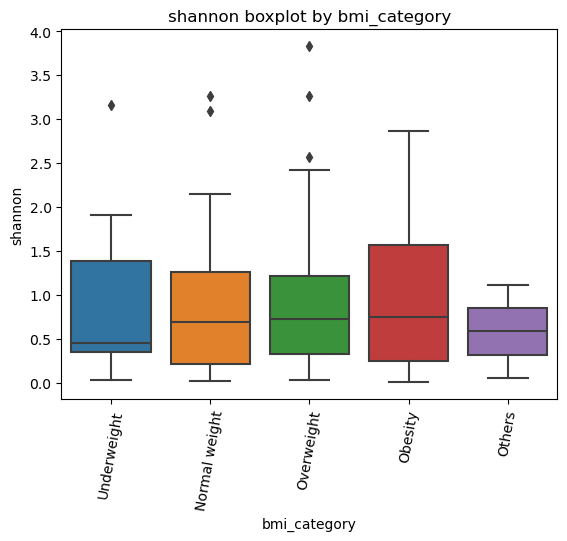

In [11]:
types = category_dropdown.value

vector = "shannon" # or "evenness"

div = q2.Artifact.load(f'./data/alpha_diversity/core-metrics-results/{vector}_vector.qza').view(pd.Series)
md = pd.read_csv('./data/metadata/fungut_metadata_processed.tsv', sep='\t', index_col=0)[f'{types}']
# Concatenate the series that we provided
dd = pd.concat([div, md], axis=1, join='inner')

# make a boxplot with Faith PD on the y-axis and the selected 'type' on the x-axis (hint: look at the "by" parameter)
sns.boxplot(x=f'{types}', y = dd.columns[0], data = dd)
plt.xlabel(f'{types}')
plt.xticks(rotation = 80)
plt.ylabel(f'{vector}')
plt.title(f'{vector} boxplot by {types}')
plt.show()

# Conclusions from Faith's Phylogenetic Diversity (PD) Boxplots

**Understanding Faith's PD:**  
Faith's Phylogenetic Diversity (PD) quantifies the total branch lengths of a phylogenetic tree that span all species within a community. Essentially, it measures the amount of evolutionary history represented in a sample, with higher values indicating greater biodiversity.

## 1. Gluten Sample

**Observations:**
- Individuals without gluten restrictions exhibit the widest range of Faith's PD, suggesting higher phylogenetic diversity.
- Those diagnosed with celiac disease or gluten allergies show lower diversity, possibly due to dietary limitations or health factors.

## 2. IBD Sample

**Observations:**
- Samples labeled "Self-diagnosed" and "Diagnosed by a medical professional" display the lowest variability in Faith's PD.
- "Not provided" show large variability, which one would expect to contain people with and without the disease.
- Individuals "Diagnosed by a medical professional" have notably lower diversity, indicating a potential association between confirmed IBD and reduced microbial diversity, as we would expect.

## 3. Diet Type

**Observations:**
- Omnivores demonstrate the highest diversity range, including some extreme outliers, suggesting greater microbial diversity compared to other diet groups.
- Vegans exhibit higher diversity than vegetarians which seems a bit strange, one would expect it to be lower, but look here.

## 4. Sex

**Observations:**
- No significant differences in Faith's PD are observed between males and females, indicating that gender alone may not substantially influence phylogenetic diversity.

## 5. State Sample

**Observations:**
- Faith's PD varies across states; for instance, Tennessee (TN) and California (CA) show broader distributions, while Maryland (MD) and Massachusetts (MA) have narrower ranges.
- These differences may reflect regional dietary habits or environmental factors affecting gut microbiota.

## 6. Country Sample

**Observations:**
- The USA exhibits the broadest range of Faith's PD, possibly due to diverse diets.
- Countries like Germany and the Isle of Man show lower diversity, potentially reflecting smaller sample sizes or more uniform dietary practices.

## Overall Insights
- Higher Faith's PD is associated with broader dietary diversity and the absence of restrictive health conditions.
- Regional and national differences suggest that diet, lifestyle, and environment influence gut microbiota diversity.
- Reduced diversity in groups with medically diagnosed conditions (e.g., celiac disease, IBD) highlights the impact of health on microbial diversity.
